# Chicago Rideshare EDA using PySpark and Spark SQL

The city of Chicago recently required all rideshare companies such as Uber and Lyft to report on the trips made within the city. This presents a unique opportunity to explore the movement of individuals via rideshare in Chicago, one of the most populous cities in the United States. The dataset is somewhat substantial at ~4.5 GB but still small enough to fit in a single machine's memory. This makes it a good candidate to practice PySpark EDA in advanced of using the dataset to predict rideshare demand. 

In [2]:
# Setting up spark
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql.functions import *
conf = SparkConf().setMaster("local").setAppName("PySpark_feature_engineering")
spark = SparkSession.builder.getOrCreate()
print(spark)

In [3]:
# Bring in some manipulation tools
import pandas as pd
import pyspark.sql.functions as F

# Bring in some plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Set sqlContext from the Spark context
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

In [16]:
# Load in csv file into spark dataframe
df = spark.read.csv('/Volumes/OWC_Big_Phatty/_Datasets/Transportation_Network_Providers_-_Trips.csv', header=True)


In [45]:
# Basic summary stats - shape
print((df.count(), len(df.columns)))

(17432011, 21)


In [17]:
# Take a look at the first few rows
df.limit(5).toPandas().head()

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,...,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,022ad3b7f1320d4e52cce3d5931eb0a0cee16c48,11/01/2018 08:45:00 AM,11/01/2018 09:30:00 AM,3140,38.5,None,17031980100,None,56,47.5,...,9.1,66.6,false,1,None,None,None,41.785998518,-87.7509342894,POINT (-87.7509342894 41.785998518)
1,0377167460a4d5d5e015c642b460e56ac88dab71,11/01/2018 02:00:00 AM,11/01/2018 02:15:00 AM,1031,5.3,None,None,70,None,10,...,2.5,12.5,false,1,41.7457577128,-87.7083657043,POINT (-87.7083657043 41.7457577128),None,None,None
2,03a2ac30a46af881e6a2e6af06a3a779b67c0802,11/01/2018 08:15:00 PM,11/01/2018 09:15:00 PM,4125,49.9,17031081700,None,8,None,62.5,...,3.8,66.3,false,1,41.8920421365,-87.6318639497,POINT (-87.6318639497 41.8920421365),None,None,None
3,03fe17b0509941aa04744e9e4478ed5ded56b2eb,11/01/2018 03:45:00 AM,11/01/2018 04:15:00 AM,1229,11.7,17031831000,None,22,None,7.5,...,2.5,10,true,3,41.9160052737,-87.6750951155,POINT (-87.6750951155 41.9160052737),None,None,None
4,040590c0bf5b22f8ccf7d8f19873c612bebfd480,11/01/2018 05:00:00 PM,11/01/2018 06:00:00 PM,3383,12.3,None,17031839100,None,32,27.5,...,2.5,30,false,1,None,None,None,41.8809944707,-87.6327464887,POINT (-87.6327464887 41.8809944707)


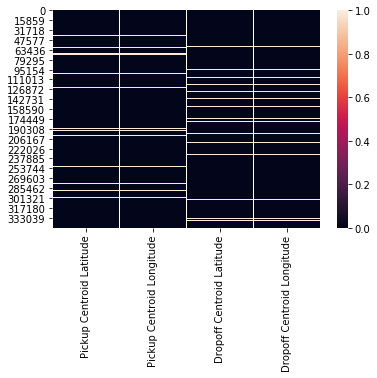

In [56]:
# Let's take a look at how much missing data is present
columns = ['Pickup Centroid Latitude','Pickup Centroid Longitude','Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']
# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.02, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isna()

# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

While this is only a small sample of the full dataset, it suggests that there are many trips that lack either a pickup location or a dropoff location. In these cases, incomplete trip location data could still be used to predict demand but only for models that seek to understand demand within the entire city at a given time or where demand is located for passengers seeking to be picked up or where passengers are seeking to be taken to. This is an important consideration - many rideshare trips begin outside the city of Chicago or end outside of city limits.

In [60]:
# Delete the pandas_df
del(pandas_df)

In [18]:
# Timestamping
df = df.withColumn("Trip Start Timestamp", 
                   F.from_unixtime(F.unix_timestamp("Trip Start Timestamp",'MM/dd/yyyy hh:mm:ss aa'),
                                   'MM/dd/yyyy HH:mm:ss'))

df = df.withColumn("Trip End Timestamp", 
                   F.from_unixtime(F.unix_timestamp("Trip End Timestamp",'MM/dd/yyyy hh:mm:ss aa'),
                                   'MM/dd/yyyy HH:mm:ss'))


In [19]:
# Import needed functions
from pyspark.sql.functions import to_date, dayofweek

# Convert to date type
df = df.withColumn('Trip Start Date', to_date('Trip Start Timestamp', 'MM/dd/yyyy HH:mm:ss')) 
df = df.withColumn('Trip End Date', to_date('Trip End Timestamp', 'MM/dd/yyyy HH:mm:ss')) 

df.select('Trip Start Timestamp', 'Trip Start Date', 'Trip End Timestamp', 'Trip End Date').show(15)

+--------------------+---------------+-------------------+-------------+
|Trip Start Timestamp|Trip Start Date| Trip End Timestamp|Trip End Date|
+--------------------+---------------+-------------------+-------------+
| 11/01/2018 08:45:00|     2018-11-01|11/01/2018 09:30:00|   2018-11-01|
| 11/01/2018 02:00:00|     2018-11-01|11/01/2018 02:15:00|   2018-11-01|
| 11/01/2018 20:15:00|     2018-11-01|11/01/2018 21:15:00|   2018-11-01|
| 11/01/2018 03:45:00|     2018-11-01|11/01/2018 04:15:00|   2018-11-01|
| 11/01/2018 17:00:00|     2018-11-01|11/01/2018 18:00:00|   2018-11-01|
| 11/01/2018 07:30:00|     2018-11-01|11/01/2018 07:45:00|   2018-11-01|
| 11/01/2018 21:30:00|     2018-11-01|11/01/2018 22:15:00|   2018-11-01|
| 11/01/2018 11:30:00|     2018-11-01|11/01/2018 11:45:00|   2018-11-01|
| 11/01/2018 05:15:00|     2018-11-01|11/01/2018 05:30:00|   2018-11-01|
| 11/01/2018 21:30:00|     2018-11-01|11/01/2018 22:15:00|   2018-11-01|
| 11/01/2018 19:00:00|     2018-11-01|11/01/2018 19

In [20]:
# Get the day of the week
df = df.withColumn('Start_Day_of_Week', dayofweek('Trip Start Date'))
df = df.withColumn('End_Day_of_Week', dayofweek('Trip End Date'))

In [21]:
# Display a random sample of day of week start/end times
df.select('Start_Day_of_Week', 'End_Day_of_Week').sample(False, 0.0018, 221).show(10)

+-----------------+---------------+
|Start_Day_of_Week|End_Day_of_Week|
+-----------------+---------------+
|                5|              5|
|                5|              5|
|                5|              5|
|                6|              6|
|                5|              5|
|                2|              2|
|                4|              4|
|                5|              5|
|                5|              5|
|                7|              7|
+-----------------+---------------+
only showing top 10 rows



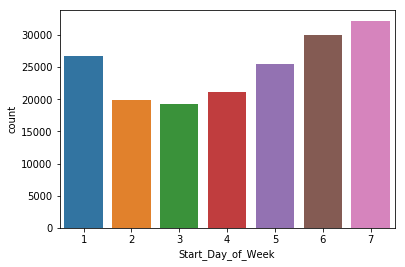

In [141]:
# Sample and convert to pandas dataframe
sample_df = df.sample(False, .01, 42).toPandas()

# Plot count plot of of day of week - most houses are listed on Thursdays and Fridays in this dataset it seems
sns.countplot(x="Start_Day_of_Week", data=sample_df)
plt.show()

The days of the week in Spark follow the convention of beginning on Sunday and ending on Saturday. Not surprisingly, Friday (6), Saturday (7), and Sunday (1) are the busiest days for rideshare demand. Most folks are out and about on these days. However, don't forget that this is just a small sample (1%) of the full dataset. 

In [144]:
# Delete sample of days of week
del(sample_df)

In [145]:
# First trip in dataset
df.agg({'Trip Start Date':'min'}).collect()[0][0]

datetime.date(2018, 11, 1)

In [146]:
# Most recent trip in dataset 
df.agg({'Trip Start Date':'max'}).collect()[0][0]

datetime.date(2018, 12, 31)

In [22]:
# Import needed functions
from pyspark.sql.functions import month, dayofmonth

# Get the month and day of month
df = df.withColumn('Start_Month', month('Trip Start Date'))
df = df.withColumn('End_Month', month('Trip End Date'))
df = df.withColumn('Start_DayofMonth', dayofmonth('Trip Start Date'))
df = df.withColumn('End_DayofMonth', dayofmonth('Trip End Date'))

df.select('Trip Start Timestamp', 'Trip End Timestamp', 'Start_Month', 'End_Month', 
         'Start_DayofMonth', 'End_DayofMonth').sample(False, 0.0018, 221).show(10)

+--------------------+-------------------+-----------+---------+----------------+--------------+
|Trip Start Timestamp| Trip End Timestamp|Start_Month|End_Month|Start_DayofMonth|End_DayofMonth|
+--------------------+-------------------+-----------+---------+----------------+--------------+
| 11/01/2018 02:45:00|11/01/2018 03:00:00|         11|       11|               1|             1|
| 11/01/2018 19:15:00|11/01/2018 19:45:00|         11|       11|               1|             1|
| 11/01/2018 13:00:00|11/01/2018 13:45:00|         11|       11|               1|             1|
| 11/02/2018 02:15:00|11/02/2018 02:30:00|         11|       11|               2|             2|
| 12/06/2018 19:15:00|12/06/2018 19:45:00|         12|       12|               6|             6|
| 12/31/2018 12:15:00|12/31/2018 13:15:00|         12|       12|              31|            31|
| 11/21/2018 23:15:00|11/21/2018 23:30:00|         11|       11|              21|            21|
| 12/06/2018 18:45:00|12/06/20

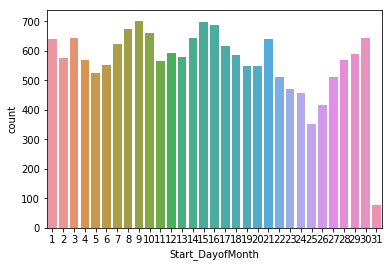

In [44]:
# We know that the dataset only covers November and December, but how common 
# are trips in the various days of the month?
# Sample and convert to pandas dataframe
sample_df = df.sample(False, .001, 42).toPandas()

# Plot count plot of of day of week - most houses are listed on Thursdays and Fridays in this dataset it seems
sns.countplot(x="Start_DayofMonth", data=sample_df)
plt.show()

/Volumes/OWC_Big_Phatty/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


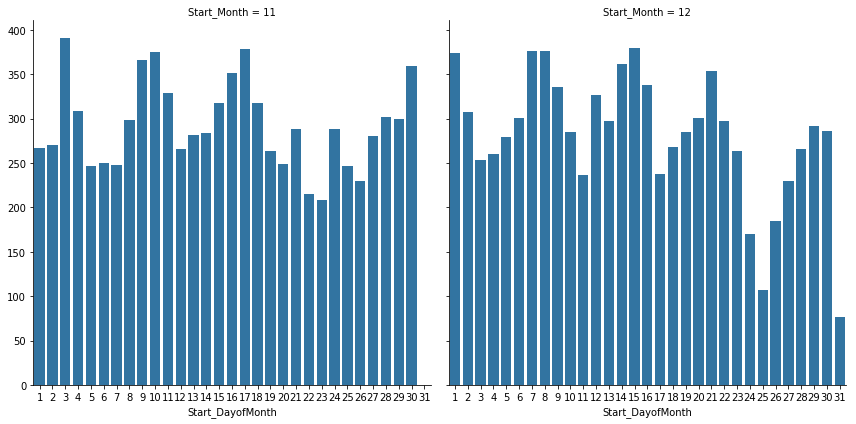

In [59]:
# Day of month faceted by month
g = sns.FacetGrid(sample_df, col="Start_Month", height=6)
g.map(sns.countplot, "Start_DayofMonth")

Unsurprisingly, Christmas quite negatively affects rideshare demand. Strangely, New Years also greatly impact demand as well in the random sample from the dataset. An important consideration is that some holidays like Christmas are likely to result in reduced rideshare demand, but other holidays like July 4th or Memorial Day are likely to result in increased rideshare demand. A strong model would likely incorporate two features around holidays that are either correlated with increase demand and those that aren't. 

The non-random increases in the number of trips (i.e. November 3, 9, 10, 17, etc.) align with Fridays and Saturdays - something expected based on the day of week frequency histogram above. Certainly, day of week is going to be an important feature in predicting rideshare demand. 

In [23]:
# Import needed functions
from pyspark.sql.functions import to_timestamp, hour

# Convert to date type
df = df.withColumn('Trip Start Timestamp', to_timestamp('Trip Start Timestamp', 'MM/dd/yyyy HH:mm:ss')) 
df = df.withColumn('Trip End Timestamp', to_timestamp('Trip End Timestamp', 'MM/dd/yyyy HH:mm:ss')) 
df = df.withColumn('Start_Hour', hour('Trip Start Timestamp')) 
df = df.withColumn('End_Hour', hour('Trip End Timestamp')) 

df.select('Trip Start Timestamp', 'Trip Start Date', 'Trip End Timestamp', 
          'Trip End Date', 'Start_Hour', 'End_Hour').show(15)

+--------------------+---------------+-------------------+-------------+----------+--------+
|Trip Start Timestamp|Trip Start Date| Trip End Timestamp|Trip End Date|Start_Hour|End_Hour|
+--------------------+---------------+-------------------+-------------+----------+--------+
| 2018-11-01 08:45:00|     2018-11-01|2018-11-01 09:30:00|   2018-11-01|         8|       9|
| 2018-11-01 02:00:00|     2018-11-01|2018-11-01 02:15:00|   2018-11-01|         2|       2|
| 2018-11-01 20:15:00|     2018-11-01|2018-11-01 21:15:00|   2018-11-01|        20|      21|
| 2018-11-01 03:45:00|     2018-11-01|2018-11-01 04:15:00|   2018-11-01|         3|       4|
| 2018-11-01 17:00:00|     2018-11-01|2018-11-01 18:00:00|   2018-11-01|        17|      18|
| 2018-11-01 07:30:00|     2018-11-01|2018-11-01 07:45:00|   2018-11-01|         7|       7|
| 2018-11-01 21:30:00|     2018-11-01|2018-11-01 22:15:00|   2018-11-01|        21|      22|
| 2018-11-01 11:30:00|     2018-11-01|2018-11-01 11:45:00|   2018-11-0

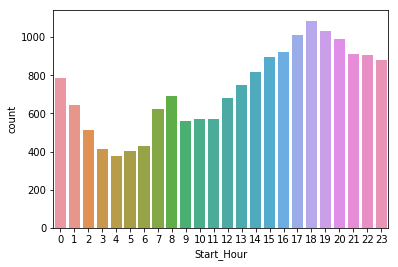

In [63]:
# Sample and convert to pandas dataframe
sample_df = df.sample(False, .001, 42).toPandas()

# Plot count plot of of day of week - most houses are listed on Thursdays and Fridays in this dataset it seems
sns.countplot(x="Start_Hour", data=sample_df)
plt.show()

There are some interesting and expected trends here - most trips take place in the afternoon and evening hours but with a noticeable bump during the morning commute hours. The highest level of demand begins as the working day ends and tapers off in the late evening. 

/Volumes/OWC_Big_Phatty/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


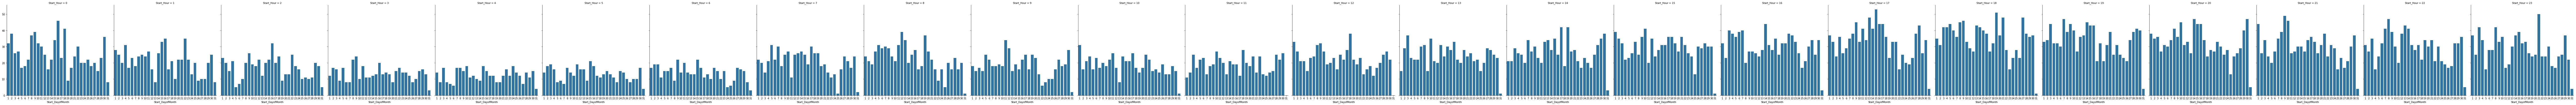

In [64]:
# Start day of month faceted by start hour
# In other words, when do trips tend to start on different days of the month?
g = sns.FacetGrid(sample_df, col="Start_Hour", height=6)
g.map(sns.countplot, "Start_DayofMonth")

/Volumes/OWC_Big_Phatty/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


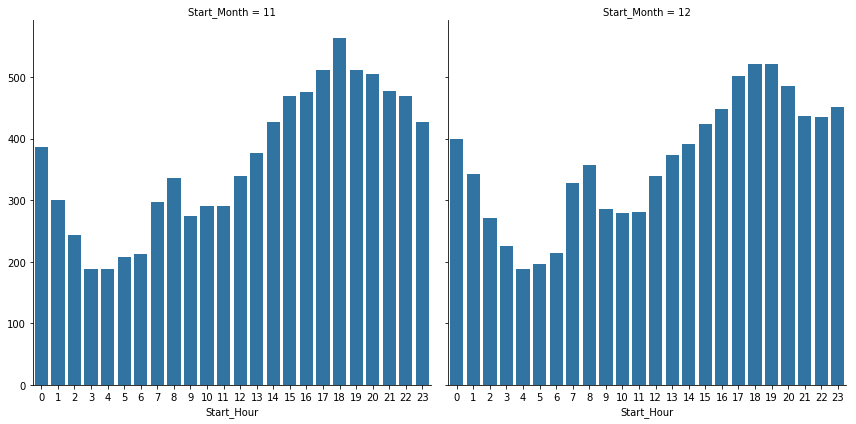

In [65]:
# Hour of day faceted by month
g = sns.FacetGrid(sample_df, col="Start_Month", height=6)
g.map(sns.countplot, "Start_Hour")

## Location of Demand

In [24]:
# First, grab a robust sample from the dataset
sample_df = df.sample(False, .01, 42).toPandas()

In [35]:
# Convert location columns to numeric for plotting
cols = ['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Fare', 'Tip',
        'Dropoff Centroid Longitude', 'Dropoff Centroid Latitude', 'Start_Hour']
sample_df[cols] = sample_df[cols].apply(pd.to_numeric, errors='coerce')

In [28]:
sample_df.dtypes

Trip ID                               object
Trip Start Timestamp          datetime64[ns]
Trip End Timestamp            datetime64[ns]
Trip Seconds                          object
Trip Miles                            object
Pickup Census Tract                   object
Dropoff Census Tract                  object
Pickup Community Area                 object
Dropoff Community Area                object
Fare                                  object
Tip                                   object
Additional Charges                    object
Trip Total                            object
Shared Trip Authorized                object
Trips Pooled                          object
Pickup Centroid Latitude             float64
Pickup Centroid Longitude            float64
Pickup Centroid Location              object
Dropoff Centroid Latitude            float64
Dropoff Centroid Longitude           float64
Dropoff Centroid Location             object
Trip Start Date                       object
Trip End D

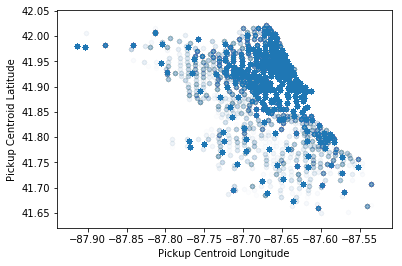

In [90]:
sample_df.plot(kind='scatter', x='Pickup Centroid Longitude', y='Pickup Centroid Latitude', alpha=0.01)

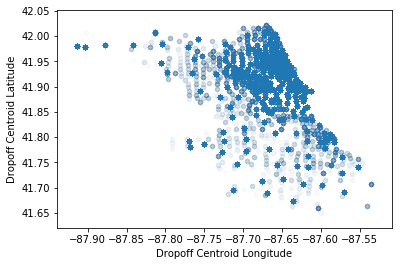

In [91]:
sample_df.plot(kind='scatter', x='Dropoff Centroid Longitude', y='Dropoff Centroid Latitude', alpha=0.01)

In [89]:
sample_df.shape

(174696, 29)

In [92]:
sample_df.head()

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,...,Dropoff Centroid Longitude,Dropoff Centroid Location,Start_Hour,End_Hour,Trip Start Date,Trip End Date,Start_Month,End_Month,Start_DayofMonth,End_DayofMonth
0,0483215f5d0fa7c8598ce17f34865e0e55075292,2018-11-01 21:30:00,2018-11-01 22:15:00,2142,24.1,17031081600,None,8,None,27.5,...,NaN,None,21,22,2018-11-01,2018-11-01,11,11,1,1
1,2cb67b09626f8ef6e550e41e5ec4ec4df83336ae,2018-11-01 19:15:00,2018-11-01 19:45:00,1940,8.1,None,None,19,None,12.5,...,NaN,None,19,19,2018-11-01,2018-11-01,11,11,1,1
2,3208b18b3c70173198888ead6a4862dcb24b8eac,2018-11-01 17:45:00,2018-11-01 18:00:00,1417,6.1,None,None,None,17,12.5,...,-87.80602,POINT (-87.8060200025 41.9465114202),17,18,2018-11-01,2018-11-01,11,11,1,1
3,e2c3aff1779cf4199ebe3939a9ef59013d2fe956,2018-11-01 17:00:00,2018-11-01 17:15:00,816,2.5,None,None,None,17,7.5,...,-87.80602,POINT (-87.8060200025 41.9465114202),17,17,2018-11-01,2018-11-01,11,11,1,1
4,e7c19e7d0458ad99f2b0c0c1078de20da1dd73c3,2018-11-01 20:15:00,2018-11-01 20:30:00,1229,5.3,None,None,30,None,7.5,...,NaN,None,20,20,2018-11-01,2018-11-01,11,11,1,1


<Figure size 1080x1080 with 0 Axes>

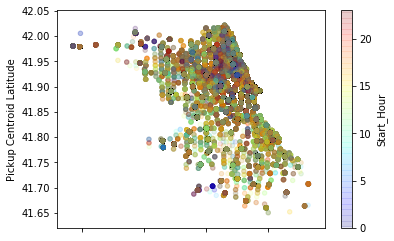

In [31]:
fig=plt.figure(figsize=(15, 15))
sample_df.plot(kind='scatter', x='Pickup Centroid Longitude', y='Pickup Centroid Latitude', alpha=0.1, 
              c ='Start_Hour', cmap=plt.get_cmap('jet'), colorbar=True)


In [32]:
spark.conf.set('spark.sql.shuffle.partitions', '5')

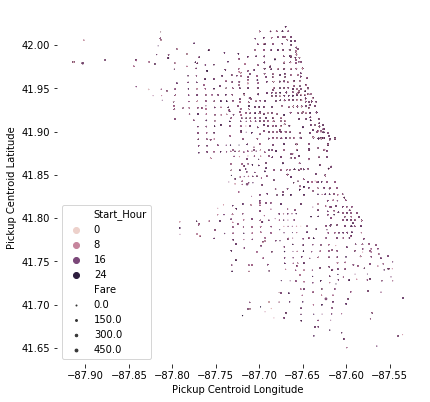

In [36]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(x="Pickup Centroid Longitude", y="Pickup Centroid Latitude",
                hue="Start_Hour", size="Fare",
                sizes=(1, 8), linewidth=0,
                data=sample_df, ax=ax)

## Time of demand
The dataset round trip start times to the nearest 15 minutes. If we group the dataset by start times, we can then visualize demand in 15 increments across the entire city. 

In [1]:
df_start = sample_df[['Trip Start Timestamp', 'Trip ID']].groupby('Trip Start Timestamp').count()

NameError: name 'sample_df' is not defined

In [2]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

data = [go.Scatter(
          x=df_start.index,
          y=df_start['Trip ID'])]

iplot(data)

NameError: name 'df_start' is not defined